# Anomaly Record Detection in Sequence Data using Support Vector Machines -  NASA Data (Multivariate)

In [31]:
import pandas as pd
import numpy as np
import os
import sklearn
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from functools import reduce
import pickle
from tabulate import tabulate

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Below methods were originally written by ***Dey Santanu***. However, I have made slight changes to some of them, because the model I'm using is different and it doesn't take in 3D arrays.

label_outliers, cleanup, read_data_with_labels, scale, get_deviations_mv, get_records_above_deviation_pctile_mv, get_classification_metrics

The methods which I wrote are;
createColumnDict, generate_dataframe_with_sliding_window, fit_train_eval_model and plot_and_tabulate, 

In [32]:
global is_anomaly_column

def label_outliers(nasa_df_row):
    if nasa_df_row['class'] == 1 :
        return 0
    else :
        return 1
    
def cleanup() :
    colnames =['time', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'class']
    train_df = pd.read_csv("data/nasa/shuttle.trn",names=colnames,sep=" ")
    test_df = pd.read_csv("data/nasa/shuttle.tst",names=colnames,sep=" ")

    # merge train and test
    merged_df = pd.concat([train_df, test_df])
    # print("Unique classes {}".format(np.unique(merged_df['class'].values, return_counts=True)))

    # drop class = 4
    minus4_df = merged_df.loc[merged_df['class'] != 4]
    # print("Frame after dropping 4 \n{}".format(minus4_df))
    # print("Unique classes after dropping 4 {}".format(np.unique(minus4_df['class'].values, return_counts=True)))

    # mark class 1 as inlier and rest as outlier
    global is_anomaly_column
    is_anomaly_column = minus4_df.apply(lambda row: label_outliers(row), axis=1)
    labelled_df = minus4_df.assign(is_anomaly=is_anomaly_column.values)

    #print("Frame after labelling outliers \n{}".format(labelled_df))
    print("Unique classes after labelling outliers {}".format(np.unique(labelled_df['class'].values, return_counts=True)))
    print("Unique outliers after labelling outliers {}".format(np.unique(labelled_df['is_anomaly'].values, return_counts=True)))

    # sort by time

    sorted_df = labelled_df.sort_values('time')

    #print("Sorted Frame\n{}".format(sorted_df))
    
    return sorted_df

def read_data_with_labels(df, timeVariantColumns, labelColumnNum):
#     df = pd.read_csv(file)
    data = df.values.astype('float64')
    tsData = df[timeVariantColumns].values.astype('float64')
    print("tsData shape ", tsData.shape)
    labels = data[:, labelColumnNum].reshape((-1,1))
    print("Labels shape ", labels.shape)
    tsDataWithLabels = np.hstack((tsData, labels))
    return tsDataWithLabels, data

def scale(data):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(data)
    return scaler, scaler.transform(data)

In [33]:
def createColumnDict(columnNames):
    """
    Generates a dictionary which contains a mapping between column names to the target column names
    
    columnNames - current names of the columns
    
    return a dictionary which contains a mapping between column names
            Ex: ["timestamp", "value", "is_anomaly"]
            {"timestamp": "timestamp_y", "value": "value_y", "is_anomaly": "is_anomaly_y"}
    """
    
    dict = {}
    for name in columnNames:
        dict[name] = name + "_current"
    
    return dict

In [34]:
def get_deviations_mv(model, X, Y):
    deviations = np.absolute(Y - model.predict(X))
    #print("Deviations Mins {}, Maxes {}".format(np.amin(deviations, axis=0), np.amax(deviations, axis=0)))    
    #print("Shape of deviations ", deviations.shape)
    return deviations

def get_records_above_deviation_pctile_mv(model, X, Y, pctile=95):
    deviations = get_deviations_mv(model, X, Y) # n_samples x n_features
    pctileDeviations = np.percentile(deviations, q=pctile, axis=0) # 1 x n_features
    #print("Deviations {}th pctiles {}".format(pctile, pctileDeviations ))
    
    deviations_above_threshold = deviations > pctileDeviations # n_samples x n_features
    #print("Shape of deviations above threshold matrix {}".format(deviations_above_threshold.shape))

    predicted_labels = np.ndarray((deviations.shape[0], 1)) # n_samples x 1
    #print("Predicted_labels shape ", predicted_labels.shape)
    predicted_labels_ref = deviations_above_threshold.any(axis = 1)
    #print("Any feature deviation > its {}th pctile deviation based is_anomaly labels {}"
    #     .format(pctile, np.unique(predicted_labels_ref, return_counts = True)))
    return predicted_labels_ref
    
def get_classification_metrics(actual, predicted):
    return confusion_matrix(actual, predicted), precision_score(actual, predicted), \
    recall_score(actual, predicted), f1_score(actual, predicted)

In [35]:
def generate_dataframe_with_sliding_window(sliding_window, df, anomaly_col_name):
    """
    
    """
    dataframes = []
    original_df = df.copy(deep=True)
    original_df = original_df.drop([anomaly_col_name], axis=1)
    for i in range(1,sliding_window+1):
        copied = original_df
        
        for j in range(1, i+1):
            copied = copied.append(pd.Series(), ignore_index=True)
        copied = copied.shift(i)
        dataframes.append(copied)
    
    df_merged = reduce(lambda left,right: right.merge(left,left_index=True,right_index=True), dataframes)
    return df_merged

In [36]:
def fit_train_eval_model(X_train, Y_train, X_test, Y_test, outlier_df, pctile, sliding_window):
    # When using without pipeline, put estimator__ before parameters
    param_grid = {'estimator__epsilon':[0.2, 0.3, 0.4, 0.5],
                  'estimator__C':[1, 25, 50],
                  'estimator__gamma':['scale', 'auto']}

    svm_clf = SVR(kernel='rbf')
    gs = GridSearchCV(MultiOutputRegressor(svm_clf), param_grid=param_grid, cv=2, scoring = 'neg_mean_squared_error', n_jobs=-1, return_train_score=True)
    gs.fit(X_train,Y_train)
    
    best_est = gs.best_estimator_
    best_params = gs.best_params_
    
    modeldir = 'model-shuttle-svr'
    if not os.path.exists(modeldir):
        os.makedirs(modeldir)
        
    modelpath = modeldir + '/sliding_window_' + str(sliding_window) + '_' + str(pctile) +'%.pkl'
    # save the best model
    with open(modelpath, 'wb') as file:
        print("Saving file ", file)
        pickle.dump(best_est, file)
    
    # get deviations for whole dataset and id records with deviations > pctile threshold and asign an is_anomaly label
    predictedAnomalyLabels = get_records_above_deviation_pctile_mv(best_est, X_test, Y_test, pctile)

    #print("Shape of predicted labels {}".format(predictedAnomalyLabels.shape))

    # outlier_df has the actual anomalies
    #print("Actual is_anomaly labels in data", np.unique(outlier_df, return_counts = True))

    # Compare calculated labels and actual labels to find confusion matrix, precision, recall, and F1
    conf_matrix, prec, recall, f1 = get_classification_metrics(np.ravel(outlier_df), predictedAnomalyLabels)
    #print("Confusion matrix \n{0}\nprecision {1:.5f}, recall {2:.5f}, f1 {3:.5f}".format(conf_matrix, prec, recall, f1))
    
    return best_params, conf_matrix, prec, recall, f1
    

In [37]:
# plotting the results for a threshold of 99.5% over 24 sliding windows
def plot_and_tabulate(results_dict):
    precision_list = []
    recall_list = []
    f1_score_list = []
    best_estimators = []

    for h in results_dict:
        results = results_dict[h]
        est_params = results[0]
        l1 = []
        l1.append(h)
        l1.append(est_params['estimator__C'])
        l1.append(est_params['estimator__epsilon'])
        l1.append(est_params['estimator__gamma'])

        best_estimators.append(l1)
        precision_list.append(results[2])
        recall_list.append(results[3])
        f1_score_list.append(results[4])

    x_tick_labels = list(results_dict.keys())

    fig, ax = plt.subplots(3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.7, wspace=0.7)

    ax[0].set_title('Precision')
    ax[0].set_xlabel('sliding window')
    ax[0].set_ylabel('Precision')
    # ax[0].set_xticklabels(x_tick_labels)
    ax[0].plot(x_tick_labels,precision_list)

    ax[1].set_title('Recall')
    ax[1].set_xlabel('sliding window')
    ax[1].set_ylabel('Recall')
    # ax[1].set_xticklabels(x_tick_labels)
    ax[1].plot(x_tick_labels,recall_list)

    ax[2].set_title('F1-score')
    ax[2].set_xlabel('sliding window')
    ax[2].set_ylabel('F1-score')
    # ax[2].set_xticklabels(x_tick_labels)
    ax[2].plot(x_tick_labels,f1_score_list)

    plt.show()
    
    table1 = tabulate(best_estimators, headers=['Sliding Window Size', 'C', 'epsilon', 'gamma' ], tablefmt='orgtbl')
    print(table1)

In [38]:
split = 0.8
sliding_window = 24
learning_rate = 0.001
cv = 3
pctile = 95.0
anomaly_col_name = 'is_anomaly'

sorted_df = cleanup()

timeVariantColumns = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8']
labelColumnNum = 10

# read data
tsDataWithLabels, data = read_data_with_labels(sorted_df, timeVariantColumns, labelColumnNum)

# scale data
scaler, tsDataScaled = scale(tsDataWithLabels)

#create the dataframe
df_original = pd.DataFrame(data=tsDataScaled, columns=['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'is_anomaly'])

Unique classes after labelling outliers (array([1, 2, 3, 5, 6, 7]), array([45586,    50,   171,  3267,    10,    13]))
Unique outliers after labelling outliers (array([0, 1]), array([45586,  3511]))
tsData shape  (49097, 8)
Labels shape  (49097, 1)


In [39]:
def run_job(sliding_window, pctile, df_original, anomaly_col_name):

    results_dict = {}

    for k in range(1, sliding_window+1):

        print("In iteration ", k)
        df = df_original.copy(deep=True)
        # This is the time series dataset made according to a sliding window.
        # This doesn't contain the current/actual values 
        merged_new = generate_dataframe_with_sliding_window(k, df_original, anomaly_col_name)
        df = df.append(pd.Series(), ignore_index=True)
        columnNames = df.columns
        df = df.rename(columns=createColumnDict(columnNames))
        merged_final = merged_new.merge(df, left_index=True, right_index=True)

        # drop rows which have NaN values. There will be k number of rows at the top with NaN values
        indexes_to_drop = []
        for i in range(0, k):
            indexes_to_drop.append(i)

        # last row will also have a NaN value
        last_index = merged_new.shape[0] - 1
        indexes_to_drop.append(last_index)
        merged_final = merged_final.drop(indexes_to_drop)

        # anomaly column name was also modified previously, hence the new name
        modified_anomaly_col_name = anomaly_col_name + "_current"

        Y_columns = list(df.columns)
        Y_columns.remove(modified_anomaly_col_name)
        X_columns = merged_new.columns

        # split the dataset into training and testing
        train_size = int(len(merged_final) * 0.8)
        train_set, test_set = merged_final[:train_size],merged_final[train_size:]

        #seperate into features and target
        X_train = train_set[X_columns]
        Y_train = train_set[Y_columns]
        X_test = test_set[X_columns]
        Y_test = test_set[Y_columns]

        # outlier_y column is not needed for forecasting, but needed later to detect outliers
        outlier_df = test_set[[modified_anomaly_col_name]]

        results = fit_train_eval_model(X_train, Y_train, X_test, Y_test, outlier_df, pctile, k)

        # save the results in a dictionary
        results_dict[k] = results
    
    return results_dict

In [41]:
dictionary1 = run_job(sliding_window = 24, pctile = 99.5, df_original = df_original, anomaly_col_name = anomaly_col_name)

In iteration  1
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_1_99.5%.pkl'>
In iteration  2
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_2_99.5%.pkl'>
In iteration  3
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_3_99.5%.pkl'>
In iteration  4
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_4_99.5%.pkl'>
In iteration  5
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_5_99.5%.pkl'>
In iteration  6
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_6_99.5%.pkl'>
In iteration  7
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_7_99.5%.pkl'>
In iteration  8
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_8_99.5%.pkl'>
In iteration  9
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_9_99.5%.pkl'>
In iteration  10
Saving file  <_io.BufferedWriter name='model-shuttle-lst

In [42]:
f = open("multivariate_results/sliding_window_24_1.pkl","wb")
pickle.dump(dictionary1,f)
f.close()

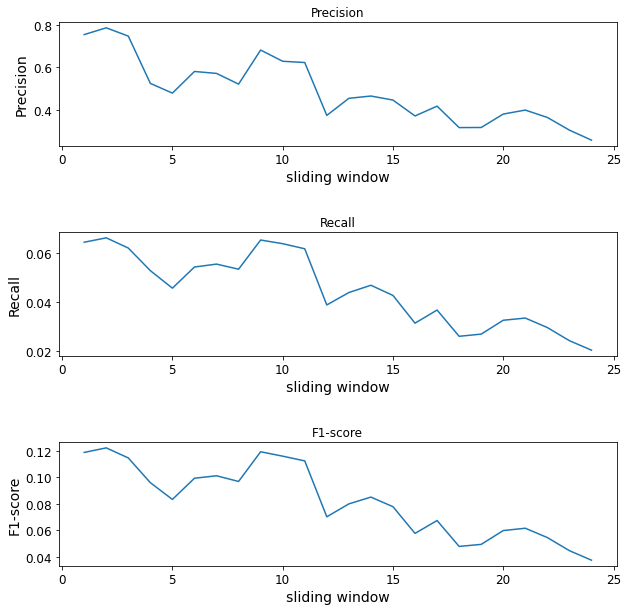

|   Sliding Window Size |   C |   epsilon | gamma   |
|-----------------------+-----+-----------+---------|
|                     1 |   1 |       0.2 | auto    |
|                     2 |   1 |       0.2 | auto    |
|                     3 |   1 |       0.2 | auto    |
|                     4 |  50 |       0.2 | scale   |
|                     5 |  25 |       0.2 | scale   |
|                     6 |  25 |       0.2 | scale   |
|                     7 |  25 |       0.2 | scale   |
|                     8 |  25 |       0.2 | scale   |
|                     9 |  50 |       0.2 | scale   |
|                    10 |  25 |       0.2 | scale   |
|                    11 |  25 |       0.2 | scale   |
|                    12 |  25 |       0.2 | scale   |
|                    13 |  25 |       0.2 | scale   |
|                    14 |  25 |       0.2 | scale   |
|                    15 |  25 |       0.2 | scale   |
|                    16 |  25 |       0.2 | scale   |
|                    17 |  2

In [43]:
# this is the results file for 99.5% threshold
# input_file1 = open("multivariate_results/sliding_window_24_1.pkl","rb")
# dictionary1 = pickle.load(input_file1)
plot_and_tabulate(dictionary1)

In [44]:
dictionary1[2]

({'estimator__C': 1, 'estimator__epsilon': 0.2, 'estimator__gamma': 'auto'},
 array([[6402,   61],
        [3134,  222]]),
 0.784452296819788,
 0.06615017878426699,
 0.12201154163231658)

In [45]:
dictionary1[9]

({'estimator__C': 50, 'estimator__epsilon': 0.2, 'estimator__gamma': 'scale'},
 array([[6359,  103],
        [3137,  219]]),
 0.6801242236024845,
 0.06525625744934446,
 0.11908646003262643)

### Running the job 24 sliding windows with 95.0 percentile threshold

In [46]:
dictionary2 = run_job(sliding_window = 24, pctile = 95.0, df_original = df_original, anomaly_col_name = anomaly_col_name)

In iteration  1
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_1_95.0%.pkl'>
In iteration  2
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_2_95.0%.pkl'>
In iteration  3
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_3_95.0%.pkl'>
In iteration  4
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_4_95.0%.pkl'>
In iteration  5
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_5_95.0%.pkl'>
In iteration  6
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_6_95.0%.pkl'>
In iteration  7
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_7_95.0%.pkl'>
In iteration  8
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_8_95.0%.pkl'>
In iteration  9
Saving file  <_io.BufferedWriter name='model-shuttle-lstm/sliding_window_9_95.0%.pkl'>
In iteration  10
Saving file  <_io.BufferedWriter name='model-shuttle-lst

In [ ]:
f = open("multivariate_results/sliding_window_24_2.pkl","wb")
pickle.dump(dictionary2,f)
f.close()

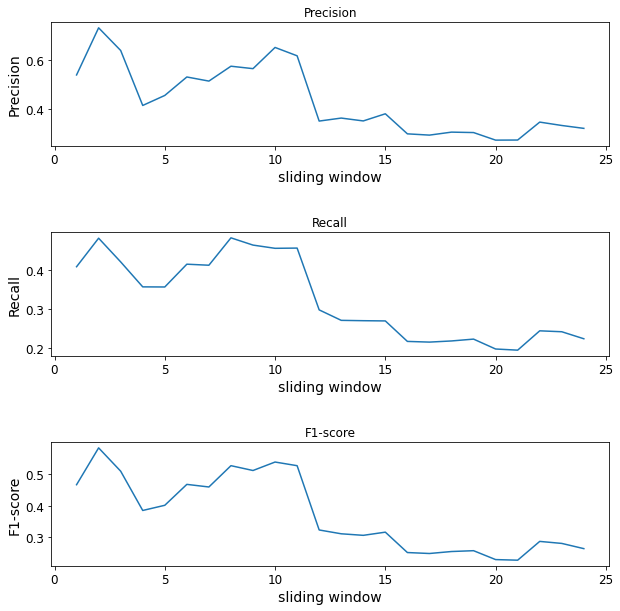

|   Sliding Window Size |   C |   epsilon | gamma   |
|-----------------------+-----+-----------+---------|
|                     1 |   1 |       0.2 | auto    |
|                     2 |   1 |       0.2 | auto    |
|                     3 |   1 |       0.2 | auto    |
|                     4 |  50 |       0.2 | scale   |
|                     5 |  25 |       0.2 | scale   |
|                     6 |  25 |       0.2 | scale   |
|                     7 |  25 |       0.2 | scale   |
|                     8 |  25 |       0.2 | scale   |
|                     9 |  50 |       0.2 | scale   |
|                    10 |  25 |       0.2 | scale   |
|                    11 |  25 |       0.2 | scale   |
|                    12 |  25 |       0.2 | scale   |
|                    13 |  25 |       0.2 | scale   |
|                    14 |  25 |       0.2 | scale   |
|                    15 |  25 |       0.2 | scale   |
|                    16 |  25 |       0.2 | scale   |
|                    17 |  2

In [16]:
# this is the results file for 95.0% threshold
# input_file2 = open("sliding_window_24_2.pkl","rb")
# dictionary2= pickle.load(input_file2)
plot_and_tabulate(dictionary2)

In [19]:
dictionary2[2]

({'estimator__C': 1, 'estimator__epsilon': 0.2, 'estimator__gamma': 'auto'},
 array([[5867,  596],
        [1733, 1623]]),
 0.7314105452906715,
 0.483611442193087,
 0.5822421524663678)

In [20]:
dictionary2[8]

({'estimator__C': 25, 'estimator__epsilon': 0.2, 'estimator__gamma': 'scale'},
 array([[5261, 1201],
        [1730, 1626]]),
 0.5751680226388397,
 0.48450536352800955,
 0.5259582726831635)